In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.chdir('/home/vasil/uni/uprajneniq/2_semestur/ohlajdaneMetali')

In [10]:
calib_path = os.path.join(os.getcwd(), 'data', 'calibration.csv')

copper_path = os.path.join(os.getcwd(), 'data', 'copper_data_2.csv')

fe_path = os.path.join(os.getcwd(), 'data', 'fe_data_2.csv')

calibration = pd.read_csv(calib_path)
copper = pd.read_csv(copper_path)
fe = pd.read_csv(fe_path)

fe = fe[fe.columns[:3]]
copper = copper[copper.columns[:3]]
print(fe.head())
print(copper.head())

   t, m  t, s  E, mV
0  0.00     0    7.3
1  0.17    10    7.2
2  0.33    20    7.0
3  0.50    30    6.8
4  0.67    40    6.7
   t, m  t, s  E, mV
0  0.00     0    7.5
1  0.17    10    7.3
2  0.33    20    7.1
3  0.50    30    6.9
4  0.67    40    6.8


## Obtain temperature data by interpolating calibration data

In [11]:
from sklearn.isotonic import IsotonicRegression

ir = IsotonicRegression()

ir.fit(calibration['E, mV'], calibration['t, C'])

room_temperature = 20

copper['T, C'] = ir.transform(copper['E, mV']) + room_temperature
fe['T, C'] = ir.transform(fe['E, mV']) + room_temperature 

print(copper.head())
print(fe.head())

   t, m  t, s  E, mV    T, C
0  0.00     0    7.5  204.25
1  0.17    10    7.3  199.25
2  0.33    20    7.1  194.25
3  0.50    30    6.9  189.25
4  0.67    40    6.8  186.75
   t, m  t, s  E, mV    T, C
0  0.00     0    7.3  199.25
1  0.17    10    7.2  196.75
2  0.33    20    7.0  191.75
3  0.50    30    6.8  186.75
4  0.67    40    6.7  184.25


## Fit exponential function to data, plot difference with reality

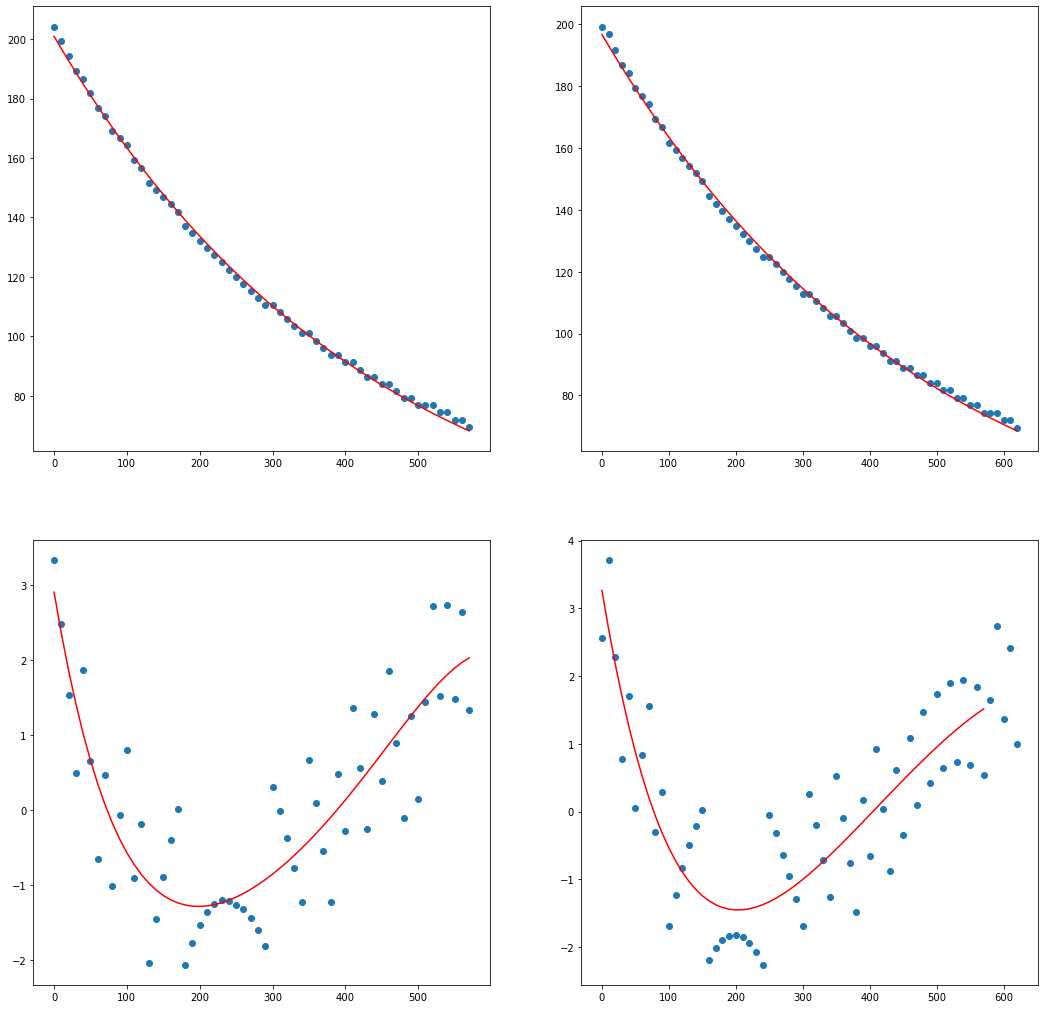

In [12]:
from scipy.optimize import curve_fit

X_c = copper['t, s']
X_fe = fe['t, s']

y_c = copper['T, C']
y_fe = fe['T, C']

# y = Ae^(-lx)

def y0(X, A, l):
    return A*np.exp(-l*X) + room_temperature


def polyift(X, *args):
    return sum([
        a_i*np.array([i**power for i in X]) for (power, a_i) in enumerate(args)
    ])


fig, ax = plt.subplots(2, 2, figsize=(18, 18))
# copper plotting
cu_params_0 = curve_fit(y0, X_c, y_c, p0=[200, 0.001])[0]
ax[0, 0].scatter(X_c, y_c)
ax[0, 0].plot(X_c, y0(X_c, *cu_params_0), 'r')

ax[1, 0].scatter(X_c, y_c - y0(X_c, *cu_params_0)) # residual after first exp approximation

polynomial_power = 5 + 1
poly_fit_params_cu = curve_fit(polyift, X_c, y_c - y0(X_c, *cu_params_0), p0=[0]*polynomial_power)[0]
ax[1, 0].plot(X_c, polyift(X_c, *poly_fit_params_cu), 'r')

# fe plotting
fe_params_0 = curve_fit(y0, X_fe, y_fe, p0=[200, 0.001])[0]
ax[0, 1].scatter(X_fe, y_fe)
ax[0, 1].plot(X_fe, y0(X_fe, *fe_params_0), 'r')

ax[1, 1].scatter(X_fe, y_fe - y0(X_fe, *fe_params_0)) # residual after first exp approximation

poly_fit_params_fe = curve_fit(polyift, X_fe, y_fe - y0(X_fe, *fe_params_0), p0=[0]*polynomial_power)[0]
ax[1, 1].plot(X_c, polyift(X_c, *poly_fit_params_fe), 'r')

plt.show()

In [ ]:
def dfit_dt(x, A, l, *args):
    return -A*l*x + sum([i*a_i*x**(i - 1) for (i, a_i) in enumerate(args[1:])])

copper_heat_capacity = { # key is temperature in K
    450: 384.6,
    400: 381.3,
    370: 379.9767
}